# Start-Code Imports

These are the imports the code came with at the top.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Starter-Code Imports (Moved)

These are the imports that were introduced later in the starter-code that have been moved to follow convention.

In [2]:
import statsmodels.api as sm

# This one had to be adjusted as the given import arch as arch didn't work
from arch import arch_model

# This one has been slightly adjusted due to deprication issue with ARMA
from statsmodels.tsa.arima.model import ARIMA




# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [4]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

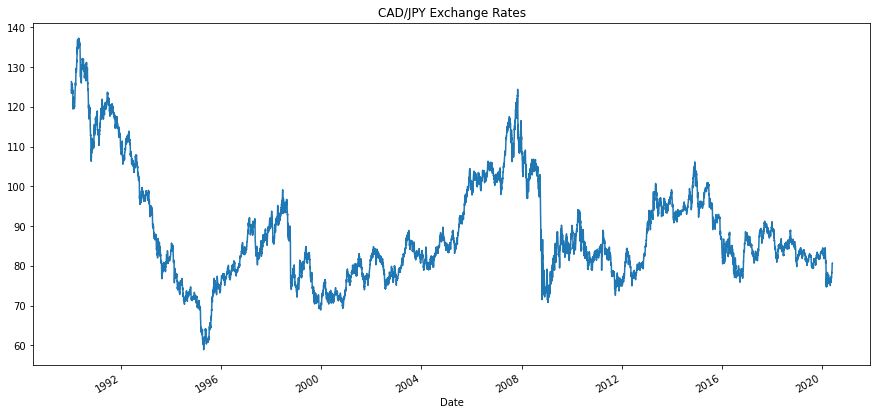

In [5]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(15,7),
                     title = 'CAD/JPY Exchange Rates'
                     ).get_figure().savefig('Image/CADorJPY_Exchange_Rates_plot.png')

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Ever since 1995, there looks to be a 4 year trend. This trend looks like the prices will go up and then drop again towards the end of the 4 year mark.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [6]:
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_noise, cad_jpy_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [7]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_HPF = pd.DataFrame()
cad_jpy_HPF['Price'] = cad_jpy_df['Price']
cad_jpy_HPF['Noise'] = cad_jpy_noise
cad_jpy_HPF['Trend'] = cad_jpy_trend
cad_jpy_HPF.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


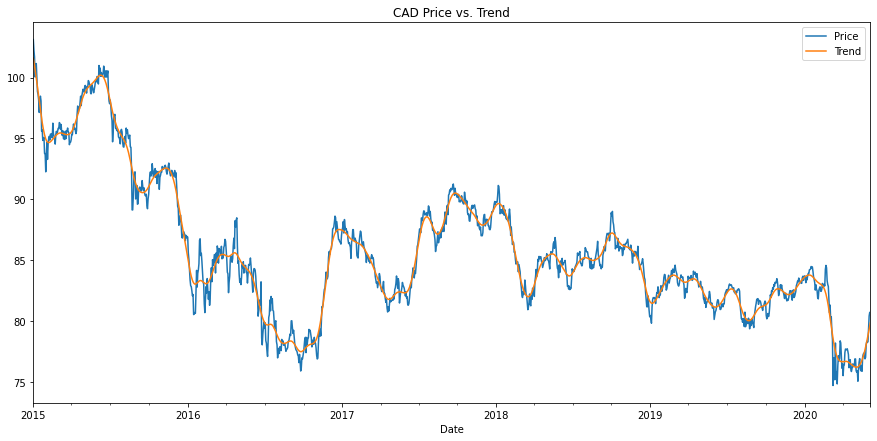

In [8]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_PvT = cad_jpy_HPF.loc['2015-01-01' :, :]
cad_jpy_PvT = cad_jpy_PvT.drop(columns=['Noise'])
line3_plot = cad_jpy_PvT.plot(figsize=(15,7),
                 title= 'CAD Price vs. Trend').get_figure().savefig('Image/CAD_Price_vs._Trend_plot.png')

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** The price tends to follow the trend, with the price currently expected to rise. However, there also seems to be a trend where the price dips before or just after the start of a year. It is rising at this point, because it recently fell at the start of 2020.

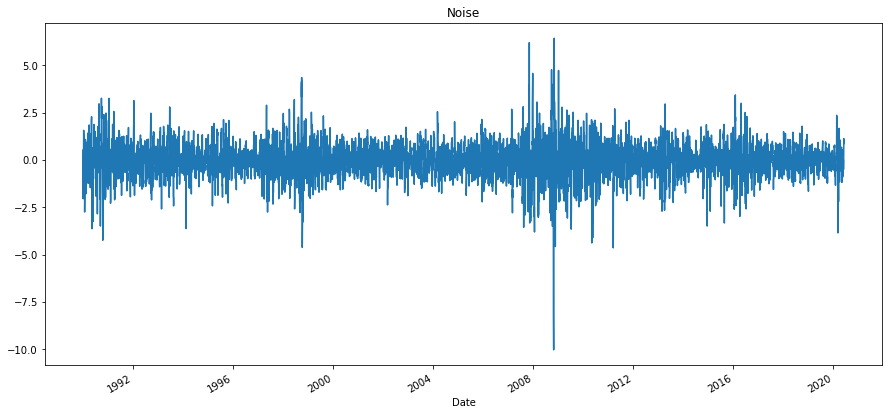

In [9]:
# Plot the Settle Noise
cad_jpy_noise.plot(figsize=(15,7),
                   title= 'Noise').get_figure().savefig('Image/Noise_plot.png')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [11]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
ARMA_model = ARIMA(returns.values, order=(2, 0, 1))

# Fit the model and assign it to a variable called results
results = ARMA_model.fit()

In [12]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9752.310
Date:                Wed, 01 Jun 2022   AIC                          19514.620
Time:                        18:24:59   BIC                          19549.511
Sample:                             0   HQIC                         19526.568
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.237      0.813      -0.021       0.016
ar.L1         -0.0152      3.499     -0.004      0.997      -6.873       6.843
ar.L2         -0.0018      0.107     -0.017      0.987      -0.212       0.209
ma.L1         -0.0153      3.499     -0.004      0.997      -6.874       6.844
sigma2         0.6855      0.006    122.678      0.000       0.675       0.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11578.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The output is not the same due to the deprication.

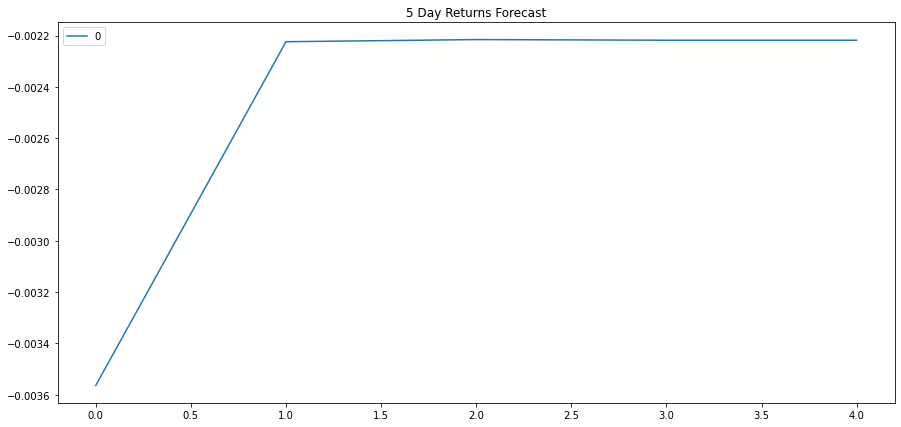

In [13]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)).plot(figsize=(15,7),
                                             title= '5 Day Returns Forecast').get_figure().savefig('Image/5_Day_Returns_Forecast_plot.png')


**Question:** Based on the p-value, is the model a good fit?

**Answer:** Based on the P-value for the second AR, the model is not a good fit since p > 0.05.

### The output is not the same due to the deprication. The answer to this question is based of of the plot and summary provided via the Starter-Code given.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [14]:
# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
arima_model = ARIMA(cad_jpy_df['Price'], order=(3,1,1))

# Fit the model
arima_result = arima_model.fit()

C:\Users\Rae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Rae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Rae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [15]:
# Output model summary results:
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7929
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -8747.358
Date:                Wed, 01 Jun 2022   AIC                          17504.716
Time:                        18:25:10   BIC                          17539.607
Sample:                             0   HQIC                         17516.664
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0142      0.746     -0.019      0.985      -1.477       1.448
ar.L2          0.0056      0.023      0.238      0.812      -0.040       0.051
ar.L3         -0.0096      0.009     -1.061      0.289      -0.027       0.008
ma.L1         -0.0138      0.746     -0.018      0.985      -1.476       1.448
sigma2         0.5320      0.004    118.509      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9186.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Rae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


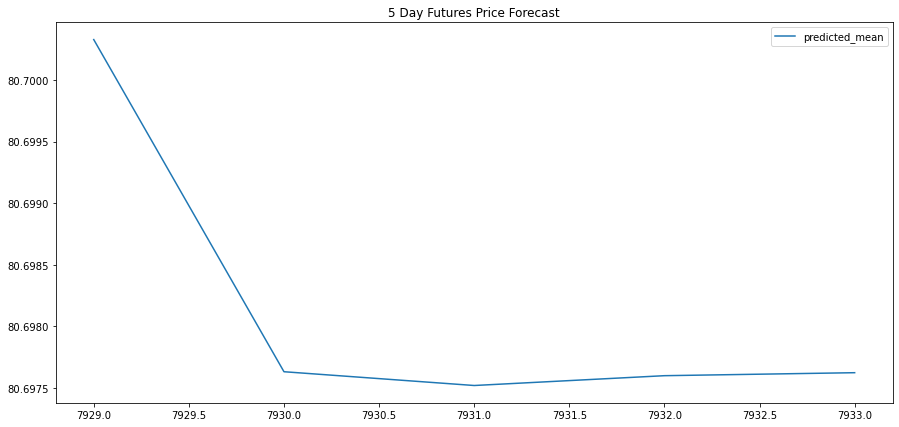

In [16]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_result.forecast(steps=5)).plot(figsize=(15,7),
                                                  title='5 Day Futures Price Forecast').get_figure().savefig('Image/5_Day_Future_Price_Forecast_plot.png')


**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The Arima model forecasts that the Japanse Yes price will fall in the near term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [17]:
# Estimate a GARCH model:
model = arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
res = model.fit(disp='off')

In [18]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Wed, Jun 01 2022   Df Residuals:                     7928
Time:                        18:25:17   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start=last_day, 
                        horizon=forecast_horizon)


In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


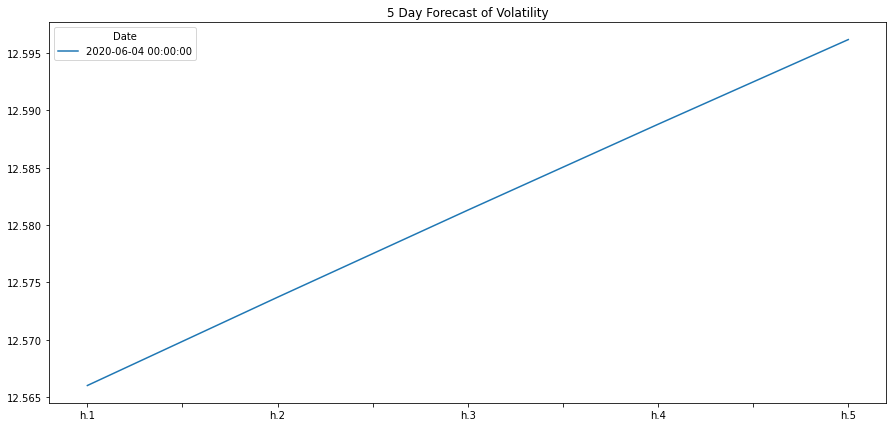

In [23]:
# Plot the final forecast
final.plot(figsize=(15,7),
           title='5 Day Forecast of Volatility').get_figure().savefig('Image/5_Day_Forecast_of_Volatility_plot.png')

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Volatility will increase.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * No.

2. Is the risk of the yen expected to increase or decrease?
    * Increase.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * No as p > 0.05